# Assignment 3 

# Table of Content
## Overview
1. Where is 307?

## Data Exploration
1. People's Behavior in terms of Dwell Time 
2. Which areas of 307 do people pass through
3. Where do people tend to linger?
4. How does dwell time change over time?

## In-depth Analysis
1. How do different zones affect people's behavior?
2. How do events affect people's behavior?
3. What is the best maintenance strategy?
4. What are other factor affect people's bahavior?

# About 307

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

In [4]:
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
#init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)

# Extra options
# pd.options.display.max_rows = 30
# pd.options.display.max_columns = 25

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
from IPython.display import Image, display, HTML

In [5]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [6]:
# store login data in login.py
%run login.py

In [7]:
# login query as multiline formatted string
# this assumes that login and pwd are defined 
# above

loginquery = f"""
mutation {{
  logIn(
      email:\"{login}\",
      password:\"{pwd}\") {{
    jwt {{
      token
      exp
    }}
  }}
}}
"""

In [8]:
import requests
url = 'https://api.numina.co/graphql'

mylogin = requests.post(url, json={'query': loginquery})
# mylogin

In [9]:
token = mylogin.json()['data']['logIn']['jwt']['token']

In [8]:
expdate = mylogin.json()
# expdate

# Explore the Data!

Now that you've been provided with the context, before we present our analysis, it's time for YOU to explore the data! As mentioned, the following are the full areas covered by the three cameras:

Streetscape | Under Raincoat | Outside
------------- | -------------  | -------------
![alt](streetscape_sandbox.png) | ![alt](underraincoat_sandbox.png) | ![alt](outside_sandbox.png)

As you see in the above images, each area essentially consists of two parts: objects such as tables and chairs, and empty spaces presumably for walking. Based on this reasoning, we have defined the following smaller behaviour zones so as to perform more in-depth research:

### Streetscape ###

Chair Zone | Corridor Zone | Free Zone
------------- | -------------  | -------------
![alt](BehaviorZoneImage/Streetscape-ChairZone.png) | ![alt](BehaviorZoneImage/Streetscape-PathZone.png) | ![alt](BehaviorZoneImage/Streetscape-ActivityZone.png)

### Under Raincoat ###

Chair Zone | Traffic Zone | Free Zone
------------- | -------------  | -------------
![alt](BehaviorZoneImage/UnderRaincoat-ChairZone.png) | ![alt](BehaviorZoneImage/UnderRaincoat-TrafficZone.png) | ![alt](BehaviorZoneImage/UnderRaincoat-ActivityZone.png)

### Outside ###

Chair Zone | Path Zone | -
------------- | -------------  | -------------
![alt](BehaviorZoneImage/Outside-ChairZone.png) | ![alt](BehaviorZoneImage/Outside-PathZone.png) | ![alt](blank.png)

Note that we have to be aware of the fact that the chairs can be moved and that the above images may not necessarily reflect the layout of the room during the whole period of data collection. Specifically, the three sets of chairs in the Under Raincoat area can be easily moved; thus in the initial exploration, we will not be investigating the Chair Zone of Under Raincoat. 

Nonetheless, notice that they are included in the Free Zone. We believe that it is safe to assume that the chairs would not be moved outside the Free Zone to the Traffic Zone.

Similarly, in the Streetscape area, under the assumption that it is intended to place the chairs together, it is unlikely that the group of chairs would be moved around freely and frequently due to the other obstacles in the room. As for the Outside area, it is also unlikely that the chairs would be placed in the middle of the road to block the path. Thus, we will be analyzing these two Chair Zones (while keeping the limitation in mind).

In [9]:
device_dict = {'SWLSANDBOX1':'Streetscape', 'SWLSANDBOX2':'Under Raincoat', 'SWLSANDBOX3':'Outside'}
device_ids = list(device_dict.keys())
device_names = list(device_dict.values())

# streetscape, under raincoat, outside
device_clrs = ['royalblue', 'firebrick', 'forestgreen']

In [10]:
def get_zones(device_id):
    
    query_zones = """
    query {{
      behaviorZones (
        serialnos: "{0}"
        ) {{
        count
        edges {{
          node {{
            rawId
            text
          }}
        }}
      }}
    }}
    """.format(device_id)
    
    zones = requests.post(url, json={'query': query_zones}, headers = {'Authorization':token})
    
    df = pd.DataFrame([x['node'] for x in zones.json()['data']['behaviorZones']['edges']])
    df['device'] = device_id
    
    return df

In [11]:
zones_df = pd.concat([get_zones(device_ids[i]) for i in range(3)])
zones_df = zones_df[(zones_df.text.notnull()) & 
                    (zones_df.text.str.startswith('x-')) & 
                    (zones_df.text.str.endswith('zone'))]

In [12]:
zones_df['text'] = zones_df['text'].str.replace('x-', '')

In [13]:
def get_dwell(func, ID, interval):
    '''
    func is either feedDwellTimeDistribution or zoneDwellTimeDistribution
    '''
    if func == 'feedDwellTimeDistribution':
        arg = 'serialnos: "{0}"'.format(ID)
    else:
        arg = 'zoneIds: {0}'.format(ID)
        
    query = """
    query {{
        {0}(
        {1},
        startTime: "2019-02-20T00:00:00",
        endTime: "2020-01-12T00:00:00",
        timezone: "America/New_York",
        objClasses: ["pedestrian"],
        interval: "{2}"
        ){{
        edges {{
          node {{
            time
            objClass
            pct100
            pct75
            pct50
            pct25
            mean
            count
          }}
        }}
      }}
    }}
    """.format(func, arg, interval)

    dwell = requests.post(url, json={'query': query}, 
                           headers = {'Authorization':token})
    
    df = pd.DataFrame([x['node'] for x in dwell.json()['data'][func]['edges']])
    if func == 'feedDwellTimeDistribution':
        df['device'] = ID
    else:
        df['zone'] = ID
    
    return df

In [14]:
# daily dwell time - device
feed_dwell_1d_df = pd.concat([get_dwell('feedDwellTimeDistribution', device_ids[i], '1d') 
                              for i in range(3)])

In [15]:
# daily dwell time - zone
zone_dwell_1d_df = pd.concat([get_dwell('zoneDwellTimeDistribution', z, '1d')
                             for z in zones_df['rawId'].values])

In [16]:
'''
def extract_time(df):
    df['year'] = df['time'].str[:4].astype(int)
    df['month'] = df['time'].str[5:7].astype(int)
    df['day'] = df['time'].str[8:10].astype(int)
    df['date'] = pd.to_datetime(df['time'].str[:10])
    df['hour'] = df['time'].str[11:13].astype(int)
    return df.drop('time', axis=1)
''';

In [17]:
'''
feed_dwell_df = extract_time(feed_dwell_df)
zone_dwell_df = extract_time(zone_dwell_df)
''';

In [18]:
# replace NaN with 0
feed_dwell_1d_df = feed_dwell_1d_df.fillna(0)
zone_dwell_1d_df = zone_dwell_1d_df.fillna(0)

In [19]:
# convert time to timestamp object
feed_dwell_1d_df['time'] = feed_dwell_1d_df['time'].str[:-6].apply(lambda x : pd.Timestamp(x))
zone_dwell_1d_df['time'] = zone_dwell_1d_df['time'].str[:-6].apply(lambda x : pd.Timestamp(x))
zone_dwell_1d_df.zone = zone_dwell_1d_df.zone.astype(str)

In [20]:
# add name column in addition to ID
feed_dwell_1d_df['device_name'] = [device_dict[d] for d in feed_dwell_1d_df.device]

# zone ID from int to str
zones_df.rawId = zones_df.rawId.astype(str)
zone_dict = dict(zip(zones_df.rawId, zones_df.text))
# zone name
zone_dwell_1d_df['zone_name'] = [zone_dict[z] for z in zone_dwell_1d_df.zone]

In [21]:
def get_df(groupby):
    if groupby == 'device_name':
        return feed_dwell_1d_df.copy(), device_names, device_clrs
    else:
        return zone_dwell_1d_df.copy(), list(zones_df.text), list(zones_df.colour)

In [22]:
# assign a colour to each behaviour zone
zones_df['colour'] = ['blue', 'lightblue', 'cadetblue',
                      'orangered', 'lightcoral', 
                      'palegreen', 'lightgreen']

In [23]:
# add a total column = mean * count
zone_dwell_1d_df['total'] = zone_dwell_1d_df['mean'] * zone_dwell_1d_df['count'] 
feed_dwell_1d_df['total'] = feed_dwell_1d_df['mean'] * feed_dwell_1d_df['count'] 

Recall that the timeframe of our data is approximately one year. Therefore, in the initial exploration, let's focus on the daily dwell time and daily count of pedestrains in the 307 region. 

As a starting point, explore the data using the following interactive line plot and think about these questions:
1. Is there any trend in pedesdrian count / dwell time in any of the areas / zones?
2. Where would you expect to see a bigger crowd? Is any of the areas / zones more popular than others?

Tip: You can click the legend on the right to include/exclude a line on the plot.

In [24]:
metric_list = ['count', 'mean', 'pct100', 'pct75', 'pct50', 'pct25', 'total']

In [25]:
def plot_timeline(groupby, metric):
    '''
    device_or_zone is either 'device_name' or 'zone_name';
    metric is a value in ['count', 'mean', 'pct100', 'pct75', 'pct50', 'pct25', 'total']
    '''
    df, byvals, clrs = get_df(groupby)
    
    fig = go.Figure()
    
    # line plot for each name
    for i in range(len(byvals)):
        sub_df = df[df[groupby] == byvals[i]]
        fig.add_trace(go.Scatter(x=sub_df.time, y=sub_df[metric], line_color=clrs[i], name=byvals[i]))
    
    # layout - axes labels
    fig.update_layout(
        xaxis_title="time",
        yaxis_title=metric,
        xaxis_rangeslider_visible=True
    )
    # title
    if metric != 'count':
        fig.update_layout(title=f"pedestrian dwell time ({metric}) grouped by '{groupby}'")
    else:
        fig.update_layout(title=f"pedestrian count grouped by '{groupby}'")
    
    fig.show()
    

In [26]:
_ = interact(plot_timeline, 
             groupby=widgets.RadioButtons(options=['device_name', 'zone_name'], value='device_name'),
             metric=widgets.Dropdown(options=metric_list, value='mean')
            )

interactive(children=(RadioButtons(description='groupby', options=('device_name', 'zone_name'), value='device_…

Not too surprisingly, we observe a few peak days. The following interactive dataframe summarizes the exact locations and dates:

In [27]:
def sort_dwell_1d(groupby, sortby, ascending, top):
    df, _, _ = get_df(groupby)
    
    cols = [groupby, 'time', sortby]
    if sortby == 'count':
        cols.append('mean')
    elif sortby == 'mean':
        cols.append('count')
    else:
        cols.append('count')
        cols.append('mean')
        
    display(df.sort_values(sortby, ascending=ascending).reset_index(drop=True)
              .loc[:int(top)-1, cols])

_ = interact(sort_dwell_1d, 
             groupby=widgets.RadioButtons(options=['device_name', 'zone_name'], value='device_name'),
             sortby=widgets.Dropdown(options=metric_list, value='mean'),
             top=widgets.IntSlider(value=5, min=1, max=30, step=1, readout_format='d'),
             ascending=widgets.Checkbox(value=False, description='ascending'))

interactive(children=(RadioButtons(description='groupby', options=('device_name', 'zone_name'), value='device_…

In [28]:
def plot_boxplot(groupby, metric):
    fig = go.Figure()
    
    df, byvals, clrs = get_df(groupby)
    
    for i in range(len(byvals)):
        # Use x instead of y argument for horizontal plot
        fig.add_trace(go.Box(x=df.loc[df[groupby]==byvals[i], metric], name=byvals[i],
                             marker_color=clrs[i], boxpoints='outliers'))

    # layout - axes labels
    fig.update_layout(
        xaxis_title=metric,
        xaxis_rangeslider_visible=True
    )
    # title
    if metric != 'count':
        fig.update_layout(title=f"distribution of pedestrian dwell time ({metric}) grouped by '{groupby}'")
    else:
        fig.update_layout(title=f"distribution of pedestrian count grouped by '{groupby}'")
    
    fig.show()
    

In [29]:
_ = interact(plot_boxplot, 
             groupby=widgets.RadioButtons(options=['device_name', 'zone_name'], value='device_name'),
             metric=widgets.Dropdown(options=metric_list, value='mean')
            )

interactive(children=(RadioButtons(description='groupby', options=('device_name', 'zone_name'), value='device_…

In [30]:
# feed_dwell_1d_df.groupby('device')['count'].describe()

In [31]:
# groupby zone_name / device_name and take the sum for the other columns
# should only investigate the count and total columns

grouped_df = zone_dwell_1d_df.groupby('zone_name').sum().reset_index(drop=False)\
                             .rename(columns={'zone_name':'name'})
grouped_df = grouped_df.append(feed_dwell_1d_df.groupby('device_name').sum().reset_index(drop=False)
                               .rename(columns={'device_name':'name'}))

In [32]:
from plotly.subplots import make_subplots

def plot_barplot(metric):
    '''
    metric is either 'count' or 'total' (dwell time)
    '''
    fig = make_subplots(rows=1, cols=3)
    
    df = grouped_df.copy()
    m = metric.split(' ')[0]
    
    for i in range(3):
        dname = device_names[i]
        total = df.loc[df.name==dname, m]
        sub_df = df[[n[1:5]==dname[1:5] for n in df.name]]
        sub_df.name = [s[-1] for s in sub_df.name.str.split('-')]
        sub_df['perc'] = sub_df[m].apply(lambda x : x / total * 100)
        
        fig.add_bar(x=sub_df.name, y=sub_df[m], name=dname, row=1, col=i+1)
        
    #fig.update_yaxes(ticksuffix="%", col=1)
    layout = go.Layout(yaxis=dict(range=[0, 100]))
    
    fig.update_layout(title=f"proportion of individual behaviour zones w.r.t. the area in terms of {metric} of pedestrians")

    fig.show()

In [33]:
_ = interact(plot_barplot, metric=widgets.RadioButtons(options=['count', 'total dwell time'], value='count'))

interactive(children=(RadioButtons(description='metric', options=('count', 'total dwell time'), value='count')…

In [34]:
'''
def boxplot_dwell(groupby, column, bound_factor):
    df, _, _ = get_df(groupby)
    
    q3 = df[column].quantile(0.75) 
    q1 = df[column].quantile(0.25)
    iqr = q3 - q1
    sub_df = df[(df[column] <= q3 + iqr*bound_factor) & 
                  ((df[column] >= q1 - iqr*bound_factor))]
    
    if column == 'count':
        title = f"distribution of count grouped by '{groupby}'" +\
        f" with values {bound_factor} * IQR beyond Q1/Q3 removed"
    else:
        title = f"distribution of mean dwell time grouped by '{groupby}'" +\
        f" with values {bound_factor} * IQR beyond Q1/Q3 removed"
    
    fig = px.box(sub_df, x=groupby, y=column, points="all", title=title)

    fig.show()
''';

In [35]:
'''
_ = interact(boxplot_dwell, 
             groupby=widgets.RadioButtons(options=['device_name', 'zone_name']), value='device_name',
             column=widgets.RadioButtons(options=['count', 'mean'], value='count'),
             bound_factor=widgets.FloatSlider(
                 value=1.5,
                 min=-3,
                 max=10,
                 step=0.1,
                 disabled=False,
                 continuous_update=False,
                 orientation='horizontal',
                 readout=True,
                 readout_format='.1f')
            )
''';

### Obtain heatmap for pedestrians
I'm going to plot heatmaps for important days in section.
The audience will be able to 
1. Select heatmaps of days (Do comparison)
    1.  top 1/2/4/9 days in terms of dwell counts or average dwell time
    2. event days
    3. customize 1/2/4/9 days
2. Select Quantiles for heatmaps
    1. 0 - 90 Desired Lines (10 each step)
    2. 90 - 100 Desired Spots (1 each step)
3. Show overlap of heatmaps between Traffics and Pedatrains for outdoor cameras.
4. Choose color of heatmap

In [18]:
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
import calendar
START_DATE = datetime(2019, 2, 20, 0, 0, 0)
END_DATE = datetime(2020, 1, 11, 0, 0, 0)
time_delta = relativedelta(days = +1)

In [2]:
import pandas as pd

In [10]:
## functions to get the data 
def heatmap_query_gen(startTime: str, endTime: str, camera:int, obj:str):
    heatmap_query = """
query {{
  feedHeatmaps(
    serialno: "{0}",
    startTime:"{1}",
    endTime:"{2}",
    objClasses:["{3}"],
    timezone:"America/New_York") {{
    edges {{
      node {{
        time
        objClass
        heatmap
      }}
    }}
  }}
}}
""".format(camera, startTime, endTime,obj)
    return heatmap_query
def get_heatmap_data(camera: int, obj: str, start_times:list, end_times:list):
    heatmap_df = pd.DataFrame(columns = ['startTime', 'endTime', 'heatMap', 'obj'])
    i = 0
    while i < len(start_times):
        heatmap_data = requests.post(url, json={'query': heatmap_query_gen(start_times[i].strftime('%Y-%m-%dT%H:%M:%S'), 
                                                                                end_times[i].strftime('%Y-%m-%dT%H:%M:%S'), camera, obj)}, 
                                                                                headers = {'Authorization':token})
        heatmap_json = heatmap_data.json()
        if heatmap_json['data']:
            if 'feedHeatmaps' in heatmap_json['data']:
                heatmap = heatmap_json['data']['feedHeatmaps']['edges'][0]['node']['heatmap']
                temp_df = pd.DataFrame({"startTime":start_times[i], "endTime":end_times[i], 'heatMap':heatmap, 'obj': obj})
                heatmap_df = heatmap_df.append(temp_df, ignore_index = True)
        i = i + 1
    return heatmap_df
def generate_consecutive_times(start_time: datetime, end_time: datetime, interval: relativedelta):
    ## the first element in the list are the start times
    time = [[], []]
    current_time = start_time
    while current_time < end_time:
        time[0].append(current_time)
        time[1].append(current_time + interval)
        current_time = current_time + interval
    return time
def daily_heatmap_data(df):
    return df.groupby(['startTime', 'endTime'])['heatMap'].apply(list).reset_index(name='heatMapMatrix')

In [33]:
## load the data, it takes a lot of time, so we do it camera by camera
all_time = generate_consecutive_times(START_DATE, END_DATE, time_delta)
outside_heatmap_pedestrian = daily_heatmap_data(get_heatmap_data('SWLSANDBOX2', 'pedestrian', all_time[0], all_time[1]))

In [35]:
streetscape_heatmap_pedestrian = daily_heatmap_data(get_heatmap_data('SWLSANDBOX1', 'pedestrian', all_time[0], all_time[1]))

In [39]:
underraincoat_heatmap_pedestrian_1 = daily_heatmap_data(get_heatmap_data('SWLSANDBOX3', 'pedestrian', all_time[0][0:100], all_time[1][0:100]))

In [40]:
underraincoat_heatmap_pedestrian_2 = daily_heatmap_data(get_heatmap_data('SWLSANDBOX3', 'pedestrian', all_time[0][100:200], all_time[1][100:200]))

In [41]:
underraincoat_heatmap_pedestrian_3 = daily_heatmap_data(get_heatmap_data('SWLSANDBOX3', 'pedestrian', all_time[0][200:], all_time[1][200:]))

In [42]:
underraincoat_heatmap_pedestrian = underraincoat_heatmap_pedestrian_1.append(
    underraincoat_heatmap_pedestrian_2).append(
    underraincoat_heatmap_pedestrian_3).reset_index(drop = True)

In [ ]:
sorted_avg_dwell_time_days = []
sorted_dwell_count_days = []
event_days = [] ## sorted by number of people

In [187]:
## Plot streetscape heatmap
## First, check how many plots the audience wants to show, input p
## Then, let the user to choose the day: IntRangeSlider
def get_daily_matrix(day: datetime, percentile: int, camera: str):
    data = []
    if camera == 'Outside Camera':
        data = list(outside_heatmap_pedestrian[outside_heatmap_pedestrian['startTime'] == day]['heatMapMatrix'])
    elif camera == 'StreetScape Camera':
         data = list(streetscape_heatmap_pedestrian[streetscape_heatmap_pedestrian['startTime'] == day]['heatMapMatrix'])
    elif camera == 'UnderRainCoat Camera':
        data = list(underraincoat_heatmap_pedestrian[underraincoat_heatmap_pedestrian['startTime'] == day]['heatMapMatrix'])
    if data: 
        p = np.percentile([i[2] for i in data[0]], percentile)
        filtered = list(filter(lambda x : x[2] >= p, data[0]))
        x = [i[0] for i in filtered] 
        y = [i[1] for i in filtered]
        density = [i[2] for i in filtered]
        return [x, y, density]
    else:
        return []
def handle_not_exist_day(day):
    print('There is no pedestrian recorded on {0}.{1}.{2}, please select another day.'.format(day.year, day.month, day.day))
def plot_streetscape_heatmap(percentile, day1:datetime, day2:datetime, day3: datetime, day4: datetime,
                             day5:datetime, day6:datetime, day7: datetime, day8: datetime, day9: datetime, mode: str, camera: str):
    fig = plt.figure(figsize=(16,11))
    days = [day1, day2, day3, day4, day5, day6, day7, day8, day9]
    if camera == "Outside Camera":
        image = mpimg.imread('outside_sandbox.png')
    elif camera == "StreetScape Camera":
        image = mpimg.imread('streetscape_sandbox.png')
    elif camera == "UnderRainCoat Camera":
        image = mpimg.imread('underraincoat_sandbox.png')
    if mode == "Days with the most dwell counts":
        days = days
    elif  mode == "Days with the highest mean dwell time":
        days = days
    elif mode == "Event Days with most pedestrian":
        days = days
    elif mode == "Customize":
         days = days
    axes = []
    for i in range(0,9):
        day_data = get_daily_matrix(days[i], percentile, camera)
        ax = fig.add_subplot(3, 3, i+1)
        axes.append(ax)
        if not (day_data):
            handle_not_exist_day(days[i])
        else:
            ax = fig.add_subplot(3, 3, i+1)
            ax.scatter(day_data[0], y = day_data[1], c=day_data[2], s=1, cmap= plt.cm.nipy_spectral)
        ax.imshow( image, aspect='auto')
        ax.set_title("Heatmap on {0}.{1}.{2}".format(days[i].year, days[i].month, days[i].day))
        ax.axis('off')
widgets.interact_manual(plot_streetscape_heatmap, day1=widgets.DatePicker(value=pd.to_datetime('2019-02-20')), 
                                                              day2=widgets.DatePicker(value=pd.to_datetime('2019-02-21')),
                                                              day3=widgets.DatePicker(value=pd.to_datetime('2019-02-22')),
                                                              day4=widgets.DatePicker(value=pd.to_datetime('2019-02-23')), 
                                                              day5=widgets.DatePicker(value=pd.to_datetime('2019-02-20')), 
                                                              day6=widgets.DatePicker(value=pd.to_datetime('2019-02-21')),
                                                              day7=widgets.DatePicker(value=pd.to_datetime('2019-02-22')),
                                                              day8=widgets.DatePicker(value=pd.to_datetime('2019-02-23')), 
                                                              day9=widgets.DatePicker(value=pd.to_datetime('2019-02-23')), 
                                                              percentile = widgets.IntSlider(min=0, max=100, step=5, value=0),
                                                              mode = widgets.Dropdown(options=[("Days with the most dwell counts", "Days with the most dwell counts"),
                                                                                               ("Days with the highest mean dwell time", "Days with the highest mean dwell time"),
                                                                                               ("Event Days with most pedestrian", "Event Days with most pedestrian"),
                                                                                               ("Customize", "Customize")],description='Plots:'),
                                                               camera = widgets.Dropdown(options=["Outside Camera", "StreetScape Camera", "UnderRainCoat Camera"]))


interactive(children=(IntSlider(value=0, description='percentile', step=5), DatePicker(value=Timestamp('2019-0…

<function __main__.plot_streetscape_heatmap(percentile, day1: datetime.datetime, day2: datetime.datetime, day3: datetime.datetime, day4: datetime.datetime, day5: datetime.datetime, day6: datetime.datetime, day7: datetime.datetime, day8: datetime.datetime, day9: datetime.datetime, mode: str, camera: str)>

For the benefit of analyze heatmap in a single day, I want to introduce two more interative pages.
They are animations, one is for quantile, one is for hour.
So, I want to download hour heatmap of event days.

In [ ]:
## download data of 6.29 as an example, if you want to add more days, just add them to list
start_time = datetime(2019, 6, 29, 0, 0, 0)
end_time = datetime(2019, 6, 30, 0, 0, 0)
interval =  relativedelta(hours = +1)
hour_interval = generate_consecutive_times(start_time, end_time, interval)
streetscape_heatmap_pedestrian_629 = daily_heatmap_data(get_heatmap_data('SWLSANDBOX1', 'pedestrian', hour_interval[0], hour_interval[1]))

In [166]:
## store them in dictionary
streetscape_heatmap_dict = {}
outside_heatmap_dict = {}
underraincoat_heatmap_dict = {}
streetscape_heatmap_dict["2019629"] = streetscape_heatmap_pedestrian_629

In [185]:
play = widgets.Play(
    value=0,
    min=0,
    max=23,
    step=1,
    interval=5000,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider()
widgets.jslink((play, 'value'), (slider, 'value'))
widgets.HBox([play, slider])

Link(source=(Play(value=0, description='Press play', interval=5000, max=23), 'value'), target=(IntSlider(value…

In [163]:
key = str(start_time.year) + (str(start_time.month)) + (str(start_time.day))
key

'2019629'

In [186]:
def heatmap_animation_hour(camera: str, day: datetime, percentile: int, hour: int):
    hour_interval =  relativedelta(hours = +1)
    key = str(day.year) + (str(day.month)) + (str(day.day))
    fig, ax = plt.subplots(figsize=(15,10))
    if camera == "Outside Camera":
        image = mpimg.imread('outside_sandbox.png')
        data = outside_heatmap_dict[key]
    elif camera == "StreetScape Camera":
        image = mpimg.imread('streetscape_sandbox.png')
        data = streetscape_heatmap_dict[key]
    elif camera == "UnderRainCoat Camera":
        image = mpimg.imread('underraincoat_sandbox.png')
        data = underraincoat_heatmap_dict[key]
    matrix = list(data[data['startTime'] == day+ hour_interval*hour]['heatMapMatrix'])
    if matrix:
        p = np.percentile([i[2] for i in matrix[0]], percentile)
        filtered = list(filter(lambda x : x[2] >= p, matrix[0]))
        x = [i[0] for i in filtered] 
        y = [i[1] for i in filtered]
        density = [i[2] for i in filtered]
        ax.scatter(x, y, c= density, s=1, cmap= plt.cm.YlGnBu_r)
    ax.imshow(image, aspect='auto')
    ax.set_title("Hourly Heatmap Animation on {0}.{1}.{2} hour:{3}".format(day.year, day.month, day.day, hour))
    ax.axis('off')
widgets.interact(heatmap_animation_hour, camera = widgets.Dropdown(options=["StreetScape Camera", "Outside Camera","UnderRainCoat Camera"]),
                       day=[pd.to_datetime('2019-06-29')],
                       percentile = widgets.IntSlider(min=0, max=100, step=5, value=0),
                       hour = play)

interactive(children=(Dropdown(description='camera', options=('StreetScape Camera', 'Outside Camera', 'UnderRa…

<function __main__.heatmap_animation_hour(camera: str, day: datetime.datetime, percentile: int, hour: int)>

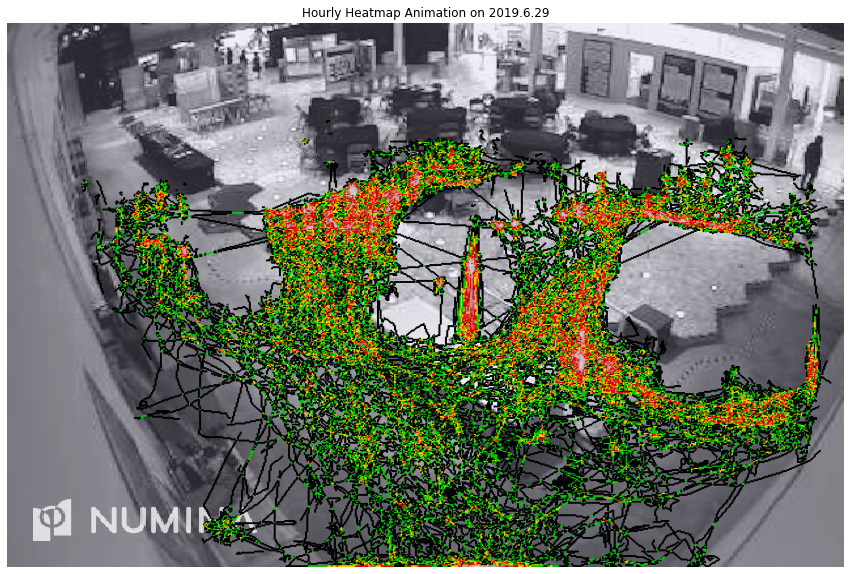

In [150]:
heatmap_animation_hour("StreetScape Camera", start_time, 20, 12)

## Event vs Non Event Days

### Subsection: Pedestrian Count

In this section, we will be exploring how poeple's behaviour differ when there is an event and when there is no event occuring. We have obtained the Sidewalk Labs' event schedule from the [website](https://www.sidewalktoronto.ca/participate/). I have recorded all the events between Febuary 20th, 2019 and January 11th, 2020.

In [42]:
event_dates = pd.read_csv('EventDates.csv')

I also have obtained the pedestrian count data. We will first explore how the pedestrian count changes in different days. 

In [43]:
outside_count_df = pd.read_csv('OverviewForOutsideCount.csv')
streetscape_count_df = pd.read_csv('OverviewForStreetScapeCount.csv')
under_rain_coat_count_df = pd.read_csv('OverviewForUnderRainCoatCount.csv')

FileNotFoundError: [Errno 2] File b'OverviewForOutsideCount.csv' does not exist: b'OverviewForOutsideCount.csv'

In [ ]:
outside_count_df.time = outside_count_df.time.str[:-6]
streetscape_count_df.time = streetscape_count_df.time.str[:-6]
under_rain_coat_count_df.time = under_rain_coat_count_df.time.str[:-6]

In [ ]:
from datetime import datetime as dt
outside_count_df.time = outside_count_df.apply(lambda x: dt.strptime(x.time, '%Y-%m-%dT%H:%M:%S'), axis = 1)
streetscape_count_df.time = streetscape_count_df.apply(lambda x: dt.strptime(x.time, '%Y-%m-%dT%H:%M:%S'), axis = 1)
under_rain_coat_count_df.time = under_rain_coat_count_df.apply(lambda x: 
                                                               dt.strptime(x.time, '%Y-%m-%dT%H:%M:%S'), axis = 1)

In [ ]:
outside_count_by_day = outside_count_df.resample('d', on='time')['pedestrians'].agg(np.sum)
streetscape_count_by_day = streetscape_count_df.resample('d', on='time')['pedestrians'].agg(np.sum)
under_rain_coat_count_df_by_day = under_rain_coat_count_df.resample('d', on='time')['pedestrians'].agg(np.sum)

In [ ]:
fig = go.Figure()
fig = fig.add_trace(go.Scatter(x=outside_count_by_day.index, y=outside_count_by_day.values, 
                         name="Outside",
                         line_color='royalblue'))

fig = fig.add_trace(go.Scatter(x=streetscape_count_by_day.index, y=streetscape_count_by_day.values, 
                         name="Street Scape",
                         line_color='dimgray'))

fig = fig.add_trace(go.Scatter(x=under_rain_coat_count_df_by_day.index, y=under_rain_coat_count_df_by_day.values, 
                         name="Under Rain Coat",
                         line_color='firebrick'))

fig = fig.update_layout(title_text='Pedestrians Count By Day',
                  xaxis_rangeslider_visible=True)
fig.show()

In [ ]:
sum_ped_count_by_day = outside_count_by_day + streetscape_count_by_day + under_rain_coat_count_df_by_day

In [ ]:
sum_ped_count_by_day

In [ ]:
# fig = go.Figure(boxpoints='all')
# fig.add_trace(go.Box(x=sum_ped_count_by_day.values))

From the time series line plot above, we notced that there are several days that have significantly higher pedestrian count than other days. We will examine this further in the hour granular level.

In [ ]:
outside_count_by_hour = outside_count_df.resample('H', on='time')['pedestrians'].agg(np.sum)
streetscape_count_by_hour = streetscape_count_df.resample('H', on='time')['pedestrians'].agg(np.sum)
rain_coat_count_by_hour = under_rain_coat_count_df.resample('H', on='time')['pedestrians'].agg(np.sum)

In [ ]:
fig = go.Figure()
fig = fig.add_trace(go.Scatter(x=outside_count_by_hour.index, y=outside_count_by_hour.values, 
                         name="Outside",
                         line_color='royalblue'))

fig = fig.add_trace(go.Scatter(x=streetscape_count_by_hour.index, y=streetscape_count_by_hour.values, 
                         name="Street Scape",
                         line_color='dimgray'))

fig = fig.add_trace(go.Scatter(x=rain_coat_count_by_hour.index, y=rain_coat_count_by_hour.values, 
                         name="Under Rain Coat",
                         line_color='firebrick'))

fig = fig.update_layout(title_text='Pedestrians Count By Hour',
                  xaxis_rangeslider_visible=True)
fig.show()

In [ ]:
def plot_pedestrian_count_event(event):
    '''
    Display time series pedestrian count of the event specified
    '''
    event_info = event_dates[event_dates.Event == event]
    start = dt.strptime(event_info['Starting Time'].values[0], '%Y-%m-%dT%H:%M:%S')
    end = dt.strptime(event_info['Ending Time'].values[0], '%Y-%m-%dT%H:%M:%S')
    
    outside = outside_count_by_hour[(outside_count_by_hour.index >= start) & (outside_count_by_hour.index <= end)]
    streetscape = streetscape_count_by_hour[(streetscape_count_by_hour.index >= start) & \
                                            (streetscape_count_by_hour.index <= end)]
    rain_coat = rain_coat_count_by_hour[(rain_coat_count_by_hour.index >= start) & \
                                        (rain_coat_count_by_hour.index <= end)]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=outside.index, y=outside.values, 
                         name="Outside",
                         line_color='royalblue'))

    fig.add_trace(go.Scatter(x=streetscape.index, y=streetscape.values, 
                         name="Street Scape",
                         line_color='dimgray'))

    fig.add_trace(go.Scatter(x=rain_coat.index, y=rain_coat.values, 
                         name="Under Rain Coat",
                         line_color='firebrick'))
    
    fig.add_trace(go.Scatter(x=rain_coat.index, y=outside.values+streetscape.values+rain_coat.values, 
                         name="Sum",
                         line_color='gold'))

    fig.update_layout(title_text=f'Pedestrians Count By Event: {event}',
                  xaxis_rangeslider_visible=True)
    fig.show()

In [ ]:
_ = interact(plot_pedestrian_count_event, 
             event=widgets.Dropdown(options=event_dates.Event.tolist(), value='Sidewalk Summer Open House'),
            )

### Subsection: Dwell Time

In [ ]:
# daily dwell time - device
feed_dwell_1h_df = pd.concat([get_dwell('feedDwellTimeDistribution', device_ids[i], '1h') 
                              for i in range(3)])

In [ ]:
feed_dwell_1h_df = feed_dwell_1h_df.dropna()

In [ ]:
feed_dwell_1h_df.time = feed_dwell_1h_df.time.str[:-6]

In [ ]:
feed_dwell_1h_df['device_name'] = [device_dict[d] for d in feed_dwell_1h_df.device]

In [ ]:
feed_dwell_1h_df.time = feed_dwell_1h_df.apply(lambda x: dt.strptime(x.time, '%Y-%m-%dT%H:%M:%S'), axis = 1)

In [ ]:
def plot_dwell_time_event(event, metric):
    '''
    Display time series of the matrix of the event specified
    '''
    event_info = event_dates[event_dates.Event == event]
    start = dt.strptime(event_info['Starting Time'].values[0], '%Y-%m-%dT%H:%M:%S')
    end = dt.strptime(event_info['Ending Time'].values[0], '%Y-%m-%dT%H:%M:%S')

    dwell_time_df = feed_dwell_1h_df[(feed_dwell_1h_df.time >= start) & (feed_dwell_1h_df.time <= end)]
    
    outside = dwell_time_df[dwell_time_df.device_name == 'Outside']
    streetscape = dwell_time_df[dwell_time_df.device_name == 'Streetscape']
    rain_coat = dwell_time_df[dwell_time_df.device_name == 'Under Raincoat']
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=outside.time, y=outside[metric], 
                         name="Outside",
                         line_color='royalblue'))

    fig.add_trace(go.Scatter(x=streetscape.time, y=streetscape[metric], 
                         name="Street Scape",
                         line_color='dimgray'))

    fig.add_trace(go.Scatter(x=rain_coat.time, y=rain_coat[metric], 
                         name="Under Rain Coat",
                         line_color='firebrick'))
    
    fig.update_layout(title_text=f"Distribution of Pedestrian dwell time ({metric}) By Event: {event}",
                  xaxis_rangeslider_visible=True)
    
    fig.update_layout(
        xaxis_title="time",
        yaxis_title=metric,
    )
    
    fig.show()
    
    

In [ ]:
_ = interact(plot_dwell_time_event, 
             event=widgets.Dropdown(options=event_dates.Event.tolist(), value='Sidewalk Summer Open House'),
             metric=widgets.Dropdown(options=['mean', 'pct100', 'pct75', 'pct50', 'pct25', 'total'], 
                                     value='mean')
            )

## Maintenance Strategy

In [44]:
# need hourly data so writing the query again; can combine with the previous one later
def get_dwell_by_hour(func, ID):
    '''
    func is either feedDwellTimeDistribution or zoneDwellTimeDistribution
    '''
    if func == 'feedDwellTimeDistribution':
        arg = 'serialnos: "{0}"'.format(ID)
    else:
        arg = 'zoneIds: {0}'.format(ID)
        
    query = """
    query {{
        {0}(
        {1},
        startTime: "2019-02-20T00:00:00",
        endTime: "2020-01-12T00:00:00",
        timezone: "America/New_York",
        objClasses: ["pedestrian"],
        interval: "1h"
        ){{
        edges {{
          node {{
            time
            objClass
            pct100
            pct75
            pct50
            pct25
            mean
            count
          }}
        }}
      }}
    }}
    """.format(func, arg)

    dwell = requests.post(url, json={'query': query}, 
                           headers = {'Authorization':token})
    
    df = pd.DataFrame([x['node'] for x in dwell.json()['data'][func]['edges']])
    if func == 'feedDwellTimeDistribution':
        df['device'] = ID
    else:
        df['zone'] = ID
    
    return df

In [45]:
feed_dwell_df = pd.concat([get_dwell_by_hour('feedDwellTimeDistribution', device_ids[i]) 
                           for i in range(3)])

In [46]:
# replace NaN with 0
feed_dwell_df = feed_dwell_df.fillna(0)

# convert time to timestamp object
feed_dwell_df['time'] = feed_dwell_df['time'].str[:-6].apply(lambda x : pd.Timestamp(x))

# add name column in addition to ID
feed_dwell_df['device_name'] = [device_dict[d] for d in feed_dwell_df.device]

In [47]:
import datetime as dt
from pandas.api.types import CategoricalDtype
days = [(dt.datetime(2019, 3, 4) + dt.timedelta(days=x)).strftime('%a') for x in range(0, 7)]
day_type = CategoricalDtype(categories=days, ordered=True)

feed_dwell_df['day of week'] = feed_dwell_df['time'].apply(lambda x: x.strftime('%a')).astype(day_type)
feed_dwell_df['date'] = feed_dwell_df['time'].apply(lambda x: x.strftime('%Y-%m-%d'))
feed_dwell_df['hour'] = feed_dwell_df['time'].apply(lambda x: x.strftime('%H'))
feed_dwell_df['hour'] = pd.to_numeric(feed_dwell_df['hour'])

In [55]:
daily_count = feed_dwell_df.groupby(['date', 'device_name'])['count'].max()
daily_count = pd.DataFrame(daily_count).reset_index()
daily_count['date'] = pd.to_datetime(daily_count['date'])

In [49]:
def plot_count(selected, start_date, end_date, threshold):
    '''
    device_or_zone is either 'device' or 'zone';
    selected is a list of device rawIds or zone rawIds;
    metric is a value in ['mean', 'pct100', 'pct75', 'pct50', 'pct25']
    '''
    #df = nonzero_df
    df = daily_count
        
    plot_df = df.loc[(df.date >= pd.Timestamp(start_date)) & 
                     (df.date <= pd.Timestamp(end_date))].copy()
    
    fig = go.Figure()
    
    for device in selected:
        sub_df = plot_df[plot_df['device_name'] == device]
        sub_df_under = sub_df[sub_df['count'] <= threshold]
        fig.add_trace(go.Scatter(x=sub_df_under.date, y=sub_df_under['count'], mode='lines', name=device))
        # TODO: fix string representation
        print("There are", len(sub_df_under), "days for ", device, 
              "with a daily pedestrian count under", threshold)
        print("There are", len(sub_df)-len(sub_df_under), "days for ", device, 
              "with a daily pedestrian count above", threshold)
    
    fig.update_layout(
        title="Pedestrian count under threshold grouped by device",
        xaxis_title="time",
        yaxis_title="count")
    
    fig.show()

In [50]:
# SWLSANDBOX1 = Streetscape
# SWLSANDBOX2 = Under Raincoat
# SWLSANDBOX3 = Outside
_ = interact(plot_count, 
             selected=widgets.SelectMultiple(options=device_names, value=device_names, disabled=False),
             start_date=widgets.DatePicker(value=pd.to_datetime('2019-02-20')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-12')),
             threshold=widgets.IntSlider(value=500, min=300, max=1000, step=100, readout_format='d')
            )

interactive(children=(SelectMultiple(description='selected', index=(0, 1, 2), options=('Streetscape', 'Under R…

In [51]:
# TODO: combine the two box plots to a single interactive
def plot_boxplot_count_by_day(threshold):
    fig = go.Figure()
    
    #df, byvals, clrs = get_df(groupby)
    df = feed_dwell_df[feed_dwell_df['count'] <= threshold]
    days = ['Mon', 'Tue','Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    
    for i in reversed(range(len(days))):
        # Use x instead of y argument for horizontal plot
        fig.add_trace(go.Box(x=df.loc[df['day of week']==days[i], 'count'], name=days[i]))

    # layout - axes labels
    #fig.update_layout(
    #    xaxis_title=metric,
    #    xaxis_rangeslider_visible=True
    #)
    # title
    
    fig.update_layout(
        title="Pedestrian count under threshold by day of week",
        xaxis_title="time",
        yaxis_title="count")
    
    fig.show()

In [52]:
_ = interact(plot_boxplot_count_by_day, 
             threshold=widgets.IntSlider(value=50, min=50, max=1000, step=50, readout_format='d'))

interactive(children=(IntSlider(value=50, description='threshold', max=1000, min=50, step=50), Output()), _dom…

In [53]:
def plot_boxplot_count_by_hour(threshold):
    fig = go.Figure()
    
    #df, byvals, clrs = get_df(groupby)
    df = feed_dwell_df[feed_dwell_df['count'] <= threshold]
    for j in range(7, 21):
        fig.add_trace(go.Box(x=df.loc[df['hour']==j, 'count'], name=j))

    # layout - axes labels
    #fig.update_layout(
    #    xaxis_title=metric,
    #    xaxis_rangeslider_visible=True
    #)
    # title
    
    fig.update_layout(
        title="Pedestrian count under threshold grouped by hour",
        xaxis_title="time",
        yaxis_title="count")
    
    fig.show()

In [54]:
_ = interact(plot_boxplot_count_by_hour, 
             threshold=widgets.IntSlider(value=100, min=50, max=1000, step=50, readout_format='d'))

interactive(children=(IntSlider(value=100, description='threshold', max=1000, min=50, step=50), Output()), _do…